<a href="https://colab.research.google.com/github/matule00/SGE/blob/main/NN_SVR_peak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 220)

In [245]:
SVR = pd.read_csv('SVR_peak.csv')
SVR['Time'] = pd.to_datetime(SVR['Time'])

#SVR = SVR[(SVR['prev_extrema_value'] <500) & (SVR['next_extrema_value'] <500)]
print(SVR.head())

                 Time  afrr_p    afrr_m  mfrr_p  mfrr_m  mfrr5       SVR  smoothed_SVR  first_derivative  second_derivative  inflection  extrema  time_prev  time_next  amp_diff  prev_extrema_value  next_extrema_value  \
0 2024-09-01 00:00:00     0.0 -41.30751     0.0     0.0    0.0 -41.30751    -41.950752         -1.056096           2.868656         0.0      0.0        NaN        NaN       NaN                 NaN                 NaN   
1 2024-09-01 00:01:00     0.0 -43.78149     0.0     0.0    0.0 -43.78149    -41.509988          1.937623           3.118783         0.0      2.0        NaN        NaN       NaN                 NaN                 NaN   
2 2024-09-01 00:02:00     0.0 -40.60929     0.0     0.0    0.0 -40.60929    -38.075505          5.181470           2.852085         0.0      0.0        NaN        NaN       NaN                 NaN                 NaN   
3 2024-09-01 00:03:00     0.0 -31.30371     0.0     0.0    0.0 -31.30371    -31.147047          7.641794           1.597

In [208]:
def train_model(X, y, NN_model, lr=0.005, patience_early_stop=10, patience_scheduler=5, num_of_epochs=40):
    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, indices, test_size=0.2, random_state=42)

    # Standardize the input data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Compile the model

    NN_model.compile(optimizer=Adam(learning_rate = lr), loss='mse', metrics=['mse'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience_early_stop, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patience_scheduler, min_lr=1e-6)
    history = NN_model.fit(X_train, y_train, validation_split=0.2, epochs=num_of_epochs, batch_size=16, callbacks=[early_stopping, lr_scheduler, checkpoint_callback], verbose=1)

    # Evaluate the model
    test_loss, test_mse = NN_model.evaluate(X_test, y_test)
    print(f"Test Mean Squared Error: {test_mse}")

    # Predict and visualize both outputs
    y_pred = NN_model.predict(X_test)

    # Separate predictions for both outputs
    y_pred_extrema = y_pred[:, 0]  # Predictions for the extrema value
    y_pred_time = y_pred[:, 1]  # Predictions for the time

    # Separate true values for both outputs
    y_test_extrema = y_test[:, 0]
    y_test_time = y_test[:, 1]

    # Calculate Mean Squared Error for both outputs
    mse_extrema = mean_squared_error(y_test_extrema, y_pred_extrema)
    mse_time = mean_squared_error(y_test_time, y_pred_time)

    print(f"Mean Squared Error for Extrema: {mse_extrema}")
    print(f"Mean Squared Error for Time: {mse_time}")


    # Visualize True vs Predicted for Extrema Value
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test_extrema, y_pred_extrema, alpha=0.6)
    plt.xlabel('True Extrema Values')
    plt.ylabel('Predicted Extrema Values')
    plt.title('True vs Predicted Extrema Values')

    # Visualize True vs Predicted for Time
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_time, y_pred_time, alpha=0.6)
    plt.xlabel('True Time Values')
    plt.ylabel('Predicted Time Values')
    plt.title('True vs Predicted Time Values')

    plt.tight_layout()
    plt.show()

In [139]:
def evaluate_predictions(predictions, threshold, use_absolute=False):
    """
    Evaluates the predictions based on a given threshold and optionally uses absolute values for evaluation.
    Computes Mean Squared Error (MSE) for the predictions (excluding True Negatives).

    Parameters:
        predictions (pd.DataFrame): DataFrame with 'actual_value' and 'predicted_value'.
        threshold (float): The threshold value to classify predictions as > threshold or ≤ threshold.
        use_absolute (bool): If True, uses absolute values for both actual and predicted values in calculations.
    """
    # Use absolute values if specified
    if use_absolute:
        predictions['eval_actual_value'] = np.abs(predictions['actual_value'])
        predictions['eval_predicted_value'] = np.abs(predictions['predicted_value'])
    else:
        predictions['eval_actual_value'] = predictions['actual_value']
        predictions['eval_predicted_value'] = predictions['predicted_value']

    # Define the confusion matrix categories
    TP = ((predictions['eval_actual_value'] > threshold) & (predictions['eval_predicted_value'] > threshold)).sum()  # True Positive
    FP = ((predictions['eval_actual_value'] <= threshold) & (predictions['eval_predicted_value'] > threshold)).sum()  # False Positive
    TN = ((predictions['eval_actual_value'] <= threshold) & (predictions['eval_predicted_value'] <= threshold)).sum()  # True Negative
    FN = ((predictions['eval_actual_value'] > threshold) & (predictions['eval_predicted_value'] <= threshold)).sum()  # False Negative

    # Calculate MSE excluding True Negatives
    predictions_non_tn = predictions[(predictions['eval_actual_value'] > threshold) |
                                     (predictions['eval_predicted_value'] > threshold)]
    mse = mean_squared_error(predictions_non_tn['actual_value'], predictions_non_tn['predicted_value'])

    # Create the confusion matrix
    conf_matrix = pd.DataFrame([[TP, FP], [FN, TN]],
                               columns=[f'Predicted > {threshold}', f'Predicted ≤ {threshold}'],
                               index=[f'Actual > {threshold}', f'Actual ≤ {threshold}'])

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                annot_kws={'size': 14}, linewidths=0.5)
    title_suffix = " (Absolute Values)" if use_absolute else ""
    plt.title(f'Confusion Matrix: Evaluation of Predictions > {threshold}{title_suffix}', fontsize=16)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.show()

    # Additional metrics: Percentage of correct predictions
    total_predictions = TP + TN + FP + FN
    correct_predictions = TP + TN
    percentage_correct = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0

    # Print results
    print(f"Total predictions (all values): {total_predictions}")
    print(f"Correct predictions (TP + TN): {correct_predictions}")
    print(f"Percentage of correct predictions: {percentage_correct:.2f}%")
    print(f"Mean Squared Error (excluding True Negatives): {mse:.4f}")
    print(f"Mean Standard Deviation Error (excluding True Negatives): {np.sqrt(mse):.4f}")

In [132]:
def plot_filtered_predictions(predictions, end_time='2024-09-10'):
    filtered_predictions = predictions[predictions['predicted_time'] < end_time]

    plt.figure(figsize=(20, 10))
    plt.scatter(
        filtered_predictions['predicted_time'],
        filtered_predictions['actual_svr_at_predicted_time'],
        label='Actual SVR', alpha=0.5, s=60
    )
    plt.scatter(
        filtered_predictions['predicted_time'],
        filtered_predictions['predicted_value'],
        label='Predicted SVR', color='orange', s=60
    )
    plt.scatter(
        filtered_predictions['predicted_time'],
        filtered_predictions['smoothed_SVR_at_predicted_time'],
        label='Smoothed SVR', color='green', s=60
    )
    plt.title('Prediction of Next Extrema and Time (Filtered)', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('SVR', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

In [237]:
valid_rows = SVR.dropna(subset=['time_prev', 'amp_diff', 'prev_extrema_value',
                                'last_5_SVR_values_1', 'last_5_SVR_values_2',
                                'last_5_SVR_values_3', 'last_5_SVR_values_4',
                                'last_5_SVR_values_5', 'previous_inflection_dropped'])
valid_rows = valid_rows[valid_rows['Time'] < pd.Times]
X = valid_rows[['time_prev', 'amp_diff', 'prev_extrema_value',
                'last_5_SVR_values_1', 'last_5_SVR_values_2',
                'last_5_SVR_values_3', 'last_5_SVR_values_4',
                'last_5_SVR_values_5', 'previous_inflection_dropped']].values
y = valid_rows[['next_extrema_value', 'time_next']].values  # Two outputs: extrema and time

indices = valid_rows.index

# Split data into training and testing sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, indices, test_size=0.2, random_state=42)

# Standardize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [238]:
# Define a valid checkpoint path
checkpoint_path = "weights.best.weights.h5"

# Create a callback to save the model's weights
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # Only save the weights
    monitor='val_loss',      # Monitor validation loss
    mode='min',              # Save weights for minimum val_loss
    save_best_only=True,     # Save only the best weights
    verbose=1
)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),  # Added another layer for complexity
    Dropout(0.1),
    Dense(2)  # Output layer with 2 neurons: one for next_extrema_value and one for time_next
])

Epoch 1/150
 92/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1193.3600 - mse: 1193.3600
Epoch 1: val_loss improved from inf to 119.98183, saving model to weights.best.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1118.8489 - mse: 1118.8489 - val_loss: 119.9818 - val_mse: 119.9818 - learning_rate: 0.0050
Epoch 2/150
 86/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.5148 - mse: 119.5148
Epoch 2: val_loss improved from 119.98183 to 86.81363, saving model to weights.best.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 128.0849 - mse: 128.0849 - val_loss: 86.8136 - val_mse: 86.8136 - learning_rate: 0.0050
Epoch 3/150
 90/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 171.0155 - mse: 171.0155
Epoch 3: val_loss did not improve from 86.81363
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 171.2584 - mse: 171.2584 - val_loss: 185.5171 - val_mse: 185.5171 - learning_rate: 0.0050
Epoch 4/150
 91/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 153.1230 - mse: 153.1230
Epoc

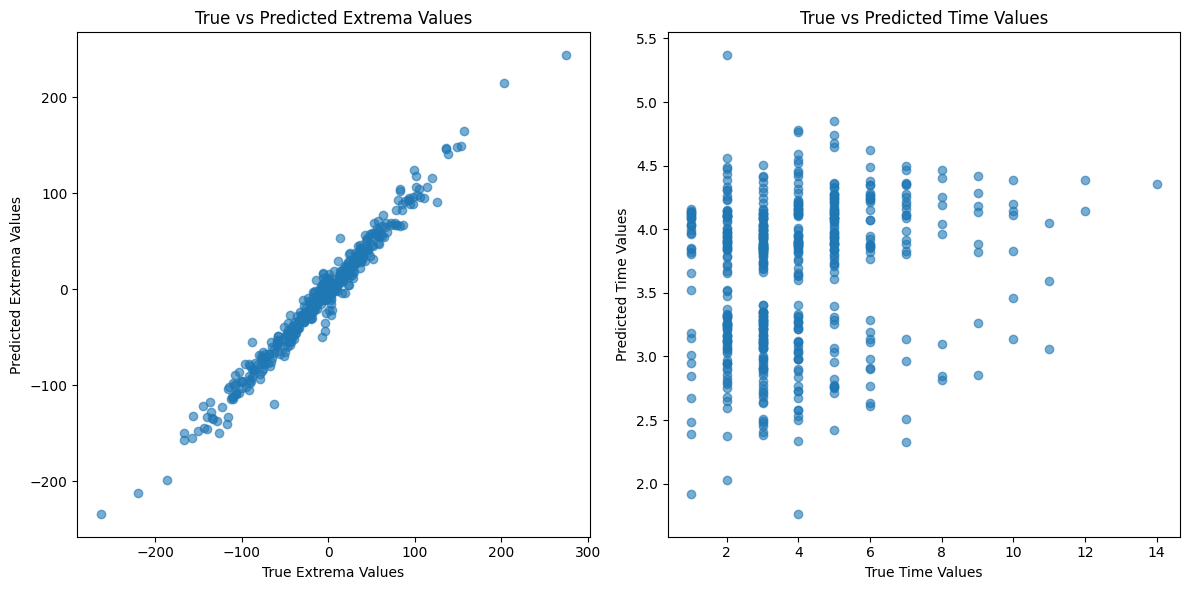

In [239]:
train_model(X, y, model, patience_early_stop=12, patience_scheduler=5, num_of_epochs=150)

In [240]:
model.load_weights('/content/weights.best.weights.h5')

y_pred1 = model.predict(X_test)
y_pred2 = model.predict(X_train)

y_pred = np.concatenate((y_pred1, y_pred2), axis=0)

y_test = np.concatenate((y_test, y_train), axis=0)

test_indices = np.concatenate((test_indices, train_indices), axis=0)

print(y_pred.shape)
print(y_test.shape)
print(test_indices.shape)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(2581, 2)
(2581, 2)
(2581,)


In [241]:
predictions = pd.DataFrame({
    'actual_value': y_test[:, 0],                # Actual extrema value
    'predicted_value': y_pred[:, 0],     # Predicted extrema value
    'actual_time': y_test[:, 1],                # Actual time to next extrema
    'predicted_time_offset': y_pred[:, 1],  # Predicted time offset
}, index=test_indices)  # Attach original indices

# Step 4: Calculate predicted time using the original SVR DataFrame
predicted_time_values = (
    SVR.loc[predictions.index, 'Time'] + pd.to_timedelta(predictions['predicted_time_offset'], unit='m')
)
predictions['predicted_time'] = predicted_time_values

# Step 5: Find SVR values at predicted times
actual_svr_at_predicted_time = []
smoothed_svr = []

for predicted_time in predicted_time_values:
    closest_idx = (SVR['Time'] - predicted_time).abs().idxmin()
    actual_svr_at_predicted_time.append(SVR.loc[closest_idx, 'SVR'])
    smoothed_svr.append(SVR.loc[closest_idx, 'smoothed_SVR'])

# Add SVR values to the DataFrame
predictions['actual_svr_at_predicted_time'] = actual_svr_at_predicted_time
predictions['smoothed_SVR_at_predicted_time'] = smoothed_svr

In [ ]:
plot_filtered_predictions(predictions)

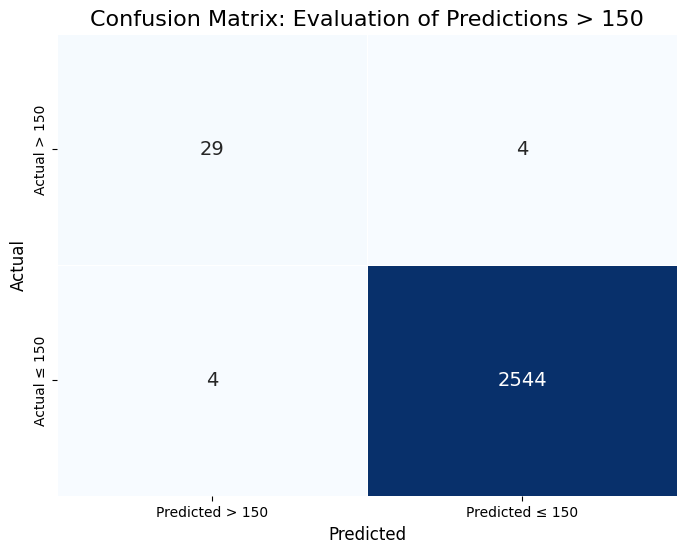

Total predictions (all values): 2581
Correct predictions (TP + TN): 2573
Percentage of correct predictions: 99.69%
Mean Squared Error (excluding True Negatives): 367.1097
Mean Standard Deviation Error (excluding True Negatives): 19.1601


In [242]:
evaluate_predictions(predictions, threshold=150, use_absolute=False)

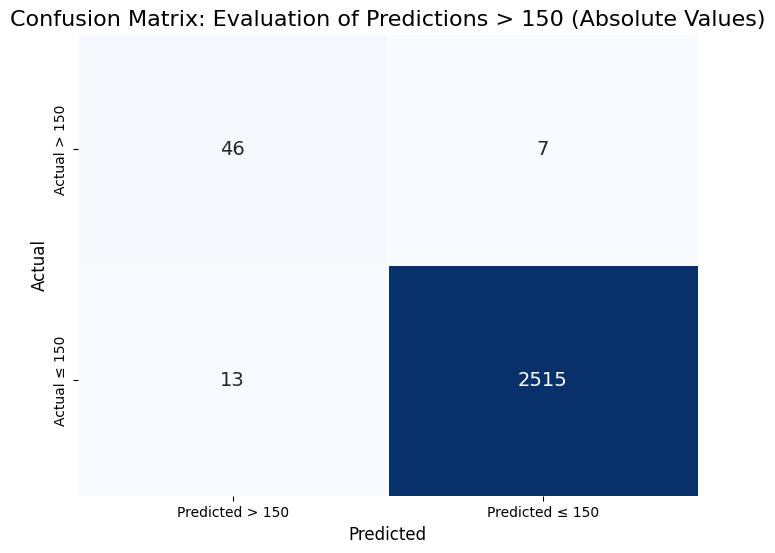

Total predictions (all values): 2581
Correct predictions (TP + TN): 2561
Percentage of correct predictions: 99.23%
Mean Squared Error (excluding True Negatives): 451.8944
Mean Standard Deviation Error (excluding True Negatives): 21.2578


In [243]:
evaluate_predictions(predictions, threshold=150, use_absolute=True)